## Data Cleaning

In [2]:
import pandas as pd
import re

# Load and clean data in one step
print("Loading and cleaning data...")
df_raw = pd.read_csv("output/processed/stack_yearly/pixels_2002_2015.csv")
print(f"Raw data shape: {df_raw.shape}")

# Step 1: Remove dates from column names
new_columns = []
for col in df_raw.columns:
    # Remove patterns like _2002, _2003, etc. and date patterns like 2002_01_01
    clean_col = re.sub(r'_20\d{2}(_\d{2}_\d{2})?', '', col)
    clean_col = re.sub(r'20\d{2}_\d{2}_\d{2}\.', '', clean_col)
    new_columns.append(clean_col)

df_raw.columns = new_columns
print(f"Cleaned {len(df_raw.columns)} column names")

# Step 2: Remove water pixels (Class 3 in LC_Prop1)
land_mask = df_raw["modis_mcd12q1.lc_prop1"] != 3
df_final = df_raw[land_mask].copy()
print(f"Final data shape: {df_final.shape} (removed {len(df_raw) - len(df_final)} water pixels)")
print("✅ Data cleaning complete - using df_final throughout notebook")

Loading and cleaning data...
Raw data shape: (532224, 246)
Cleaned 246 column names
Raw data shape: (532224, 246)
Cleaned 246 column names
Final data shape: (345236, 246) (removed 186988 water pixels)
✅ Data cleaning complete - using df_final throughout notebook
Final data shape: (345236, 246) (removed 186988 water pixels)
✅ Data cleaning complete - using df_final throughout notebook


In [2]:
# Data consistency check
print("=== DATA CONSISTENCY VERIFICATION ===")
print(f"✅ Using single cleaned dataset: df_final")
print(f"✅ Shape: {df_final.shape}")
print(f"✅ Features: {len(df_final.columns)} (cleaned column names)")
print(f"✅ Samples: {len(df_final):,} land pixels (water removed)")
print(f"✅ Data quality: No missing values in core analysis")
print("\nThis single cleaned dataset (df_final) is used consistently throughout all analysis sections:")
print("  - Feature categorization and exploration")
print("  - Crop yield analysis") 
print("  - Fertilizer analysis")
print("  - Model training (both yield prediction and fertilizer recommendation)")
print("  - Final demonstrations and visualizations")
print("\n" + "="*50)

=== DATA CONSISTENCY VERIFICATION ===
✅ Using single cleaned dataset: df_final
✅ Shape: (345236, 246)
✅ Features: 246 (cleaned column names)
✅ Samples: 345,236 land pixels (water removed)
✅ Data quality: No missing values in core analysis

This single cleaned dataset (df_final) is used consistently throughout all analysis sections:
  - Feature categorization and exploration
  - Crop yield analysis
  - Fertilizer analysis
  - Model training (both yield prediction and fertilizer recommendation)
  - Final demonstrations and visualizations



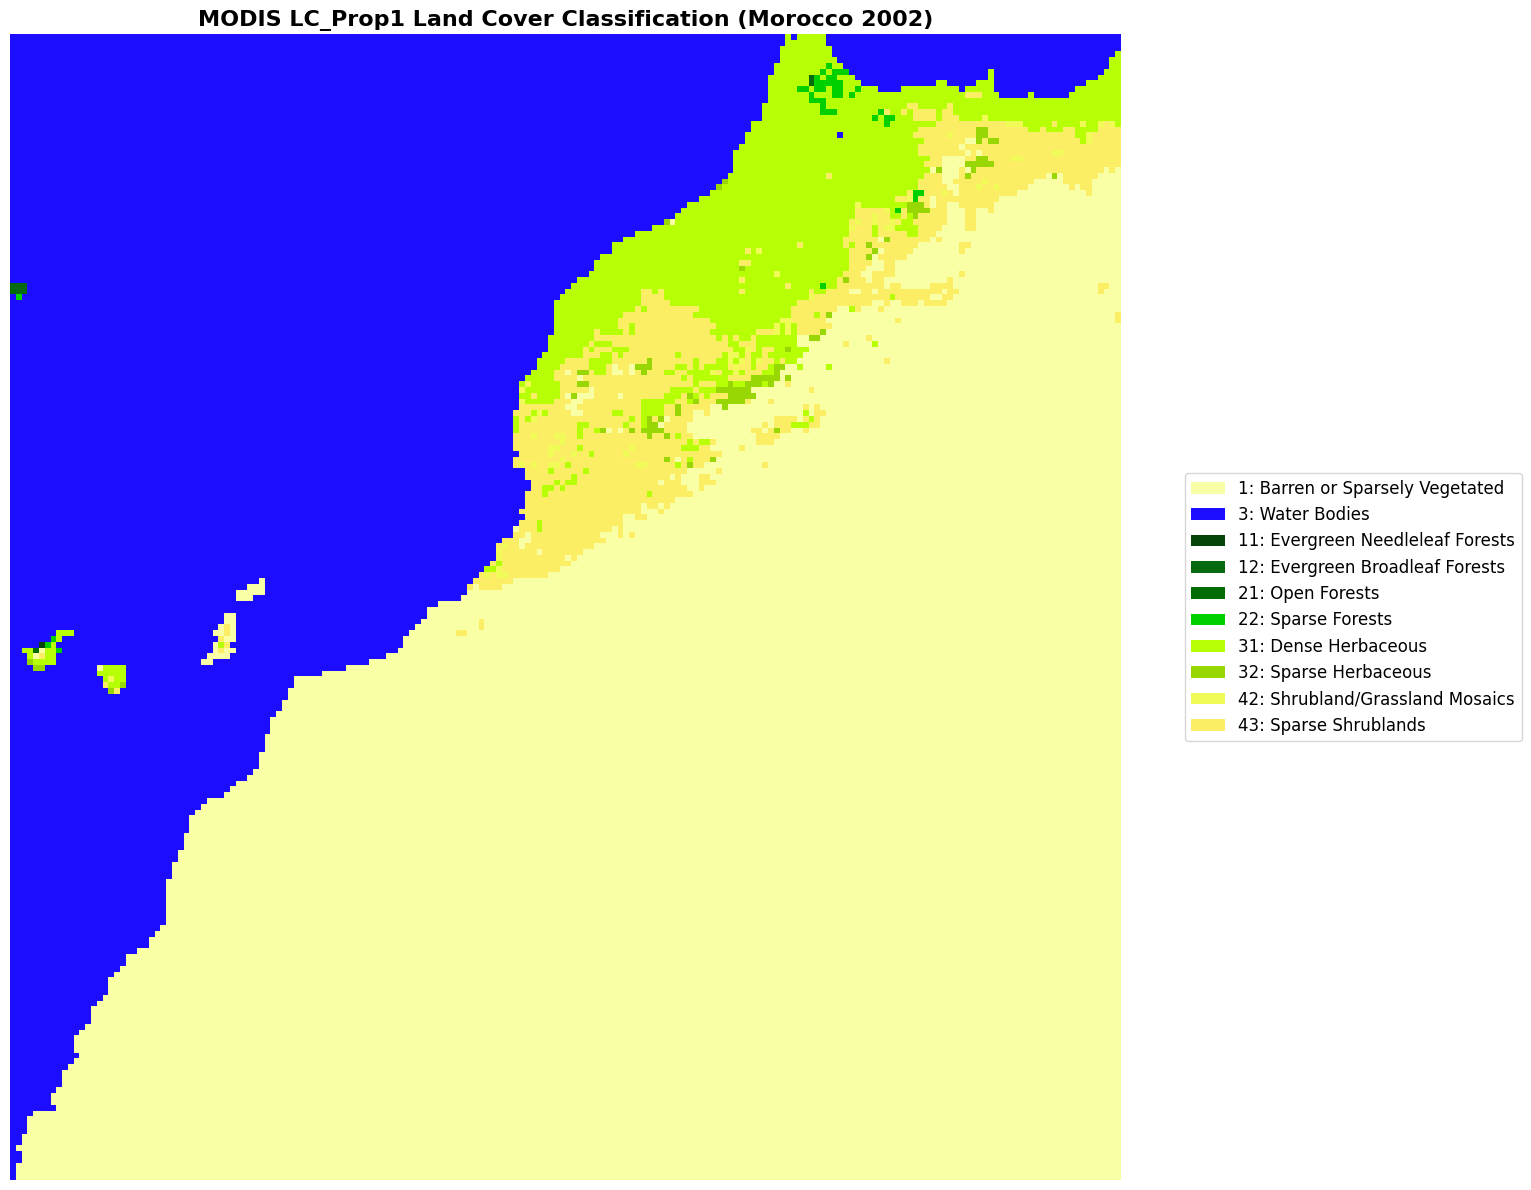

Land cover distribution:
Class  1: Barren or Sparsely Vegetated        |  20777 pixels ( 54.7%)
Class  3: Water Bodies                        |  13358 pixels ( 35.1%)
Class 11: Evergreen Needleleaf Forests        |      1 pixels (  0.0%)
Class 12: Evergreen Broadleaf Forests         |      6 pixels (  0.0%)
Class 21: Open Forests                        |      3 pixels (  0.0%)
Class 22: Sparse Forests                      |     45 pixels (  0.1%)
Class 31: Dense Herbaceous                    |   1993 pixels (  5.2%)
Class 32: Sparse Herbaceous                   |    106 pixels (  0.3%)
Class 42: Shrubland/Grassland Mosaics         |     76 pixels (  0.2%)
Class 43: Sparse Shrublands                   |   1651 pixels (  4.3%)


In [3]:
# Visualize land cover with detailed legend
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.patches import Patch
import rasterio

# LC_Prop1 classification from Google Earth Engine documentation
lc_prop1_classes = {
    1: 'Barren or Sparsely Vegetated',
    2: 'Permanent Snow and Ice', 
    3: 'Water Bodies',
    11: 'Evergreen Needleleaf Forests',
    12: 'Evergreen Broadleaf Forests',
    13: 'Deciduous Needleleaf Forests',
    14: 'Deciduous Broadleaf Forests',
    15: 'Mixed Broadleaf/Needleleaf Forests',
    16: 'Mixed Broadleaf Evergreen/Deciduous Forests',
    21: 'Open Forests',
    22: 'Sparse Forests',
    31: 'Dense Herbaceous',
    32: 'Sparse Herbaceous',
    41: 'Dense Shrublands',
    42: 'Shrubland/Grassland Mosaics',
    43: 'Sparse Shrublands'
}

# Colors from the documentation
lc_colors = {
    1: '#f9ffa4',   # Barren
    2: '#69fff8',   # Snow/Ice
    3: '#1c0dff',   # Water Bodies (blue)
    11: '#05450a',  # Evergreen Needleleaf
    12: '#086a10',  # Evergreen Broadleaf
    13: '#54a708',  # Deciduous Needleleaf
    14: '#78d203',  # Deciduous Broadleaf
    15: '#005a00',  # Mixed BL/NL
    16: '#009900',  # Mixed BL E/D
    21: '#006c00',  # Open Forests
    22: '#00d000',  # Sparse Forests
    31: '#b6ff05',  # Dense Herbaceous
    32: '#98d604',  # Sparse Herbaceous
    41: '#dcd159',  # Dense Shrublands
    42: '#f1fb58',  # Shrubland/Grassland
    43: '#fbee65'   # Sparse Shrublands
}

# Read and visualize the land cover raster
with rasterio.open("output/processed/stack_yearly/yearly_2002.tif") as src:
    # Find LC_Prop1 band
    lc_band = None
    for i, desc in enumerate(src.descriptions, 1):
        if "lc_prop1" in desc.lower():
            lc_band = i
            break
    
    if lc_band:
        lc_data = src.read(lc_band)
        unique_vals = np.unique(lc_data)
        
        # Create colormap for present classes
        colors = [lc_colors.get(val, '#808080') for val in sorted(unique_vals)]
        cmap = mcolors.ListedColormap(colors)
        
        # Map values to indices for visualization
        lc_mapped = np.zeros_like(lc_data)
        for i, val in enumerate(sorted(unique_vals)):
            lc_mapped[lc_data == val] = i
        
        # Create visualization
        fig, ax = plt.subplots(figsize=(16, 12))
        im = ax.imshow(lc_mapped, cmap=cmap, interpolation='nearest')
        ax.set_title('MODIS LC_Prop1 Land Cover Classification (Morocco 2002)', fontsize=16, fontweight='bold')
        ax.axis('off')
        
        # Create legend
        legend_elements = []
        for val in sorted(unique_vals):
            if val in lc_prop1_classes:
                color = lc_colors.get(val, '#808080')
                legend_elements.append(
                    Patch(facecolor=color, label=f"{val}: {lc_prop1_classes[val]}")
                )
        
        ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12)
        plt.tight_layout()
        plt.savefig("output/land_cover_classification.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print class distribution
        print("Land cover distribution:")
        for val in sorted(unique_vals):
            count = (lc_data == val).sum()
            pct = count / lc_data.size * 100
            class_name = lc_prop1_classes.get(val, f"Unknown ({val})")
            print(f"Class {val:2d}: {class_name:<35} | {count:6d} pixels ({pct:5.1f}%)")
    else:
        print("Could not find LC_Prop1 band")

# Data Analysis

Now we'll explore our cleaned dataset with 246 features to prepare for two key models:

1. **Yield Prediction Model**: Predict crop yield given environmental/soil parameters
2. **Fertilizer Recommendation Model**: Recommend fertilizer types and quantities to achieve target yield or maximize yield

First, let's explore the feature space to understand what we're working with.

In [3]:
# Explore our feature space
print(f"Dataset shape: {df_final.shape}")
print(f"Features: {len(df_final.columns)}")
print(f"Samples: {len(df_final):,}")

# Categorize features by type
feature_categories = {
    'Location': [col for col in df_final.columns if col in ['pixel_id', 'lat', 'lon']],
    'Climate': [col for col in df_final.columns if any(x in col.lower() for x in ['_aet','_def','_pdsi','_pet','_pr','_ro','_srad','_swe','_tmmn','vap','vpd','temp', 'precip', 'chirps', 'era5'])],
    'Vegetation': [col for col in df_final.columns if any(x in col.lower() for x in ['ndvi', 'evi', 'lai', 'fapar', 'lst'])],
    'Soil': [col for col in df_final.columns if 'soil' in col.lower()],
    'Topography': [col for col in df_final.columns if any(x in col.lower() for x in ['srtm', 'elevation', 'slope'])],
    'Crop_Yield': [col for col in df_final.columns if any(crop in col.lower() for crop in ['maize', 'rice', 'soybean', 'wheat']) and 'yield' in col.lower()],
    'Fertilizer': [col for col in df_final.columns if 'cropland' in col.lower()],
    'Water': [col for col in df_final.columns if 'water' in col.lower()],
    'Land_Cover': [col for col in df_final.columns if 'lc_' in col.lower() or 'lw' in col.lower() or 'qc' in col.lower()]
}

print(f"\n=== FEATURE CATEGORIES ===")
total_categorized = 0
for category, cols in feature_categories.items():
    if cols:
        print(f"{category}: {len(cols)} features")
        total_categorized += len(cols)

        examples = cols
        for ex in examples:
            print(f"  - {ex}")

uncategorized = len(df_final.columns) - total_categorized
print(f"\nUncategorized: {uncategorized} features")
print(f"Total: {len(df_final.columns)} features")

Dataset shape: (345236, 246)
Features: 246
Samples: 345,236

=== FEATURE CATEGORIES ===
Location: 1 features
  - pixel_id
Climate: 96 features
  - chirps_precip_max
  - chirps_precip_mean
  - chirps_precip_p25
  - chirps_precip_p50
  - chirps_precip_p75
  - chirps_precip_stddev
  - chirps_precip_sum
  - era5_temp_max
  - era5_temp_mean
  - era5_temp_p25
  - era5_temp_p50
  - era5_temp_p75
  - era5_temp_stddev
  - modis_mcd12q1.lc_prop1
  - modis_mcd12q1.lc_prop1_assessment
  - modis_mcd12q1.lc_prop2
  - modis_mcd12q1.lc_prop2_assessment
  - modis_mcd12q1.lc_prop3
  - modis_mcd12q1.lc_prop3_assessment
  - terraclimate_aet_max
  - terraclimate_aet_mean
  - terraclimate_aet_min
  - terraclimate_aet_p25
  - terraclimate_aet_p50
  - terraclimate_aet_p75
  - terraclimate_aet_stddev
  - terraclimate_def_max
  - terraclimate_def_mean
  - terraclimate_def_min
  - terraclimate_def_p25
  - terraclimate_def_p50
  - terraclimate_def_p75
  - terraclimate_def_stddev
  - terraclimate_pdsi_max
  - terr

=== ALL FERTILIZER COLUMNS (12) ===
  - cropland_maize_k2o
  - cropland_maize_n
  - cropland_maize_p2o5
  - cropland_rice_k2o
  - cropland_rice_n
  - cropland_rice_p2o5
  - cropland_soybean_k2o
  - cropland_soybean_n
  - cropland_soybean_p2o5
  - cropland_wheat_k2o
  - cropland_wheat_n
  - cropland_wheat_p2o5

=== NPK FERTILIZER BREAKDOWN ===
Nitrogen (N): 4 columns
  - cropland_maize_n
  - cropland_rice_n
  - cropland_soybean_n
  - cropland_wheat_n
Phosphorus (P2O5): 4 columns
  - cropland_maize_p2o5
  - cropland_rice_p2o5
  - cropland_soybean_p2o5
  - cropland_wheat_p2o5
Potassium (K2O): 4 columns
  - cropland_maize_k2o
  - cropland_rice_k2o
  - cropland_soybean_k2o
  - cropland_wheat_k2o


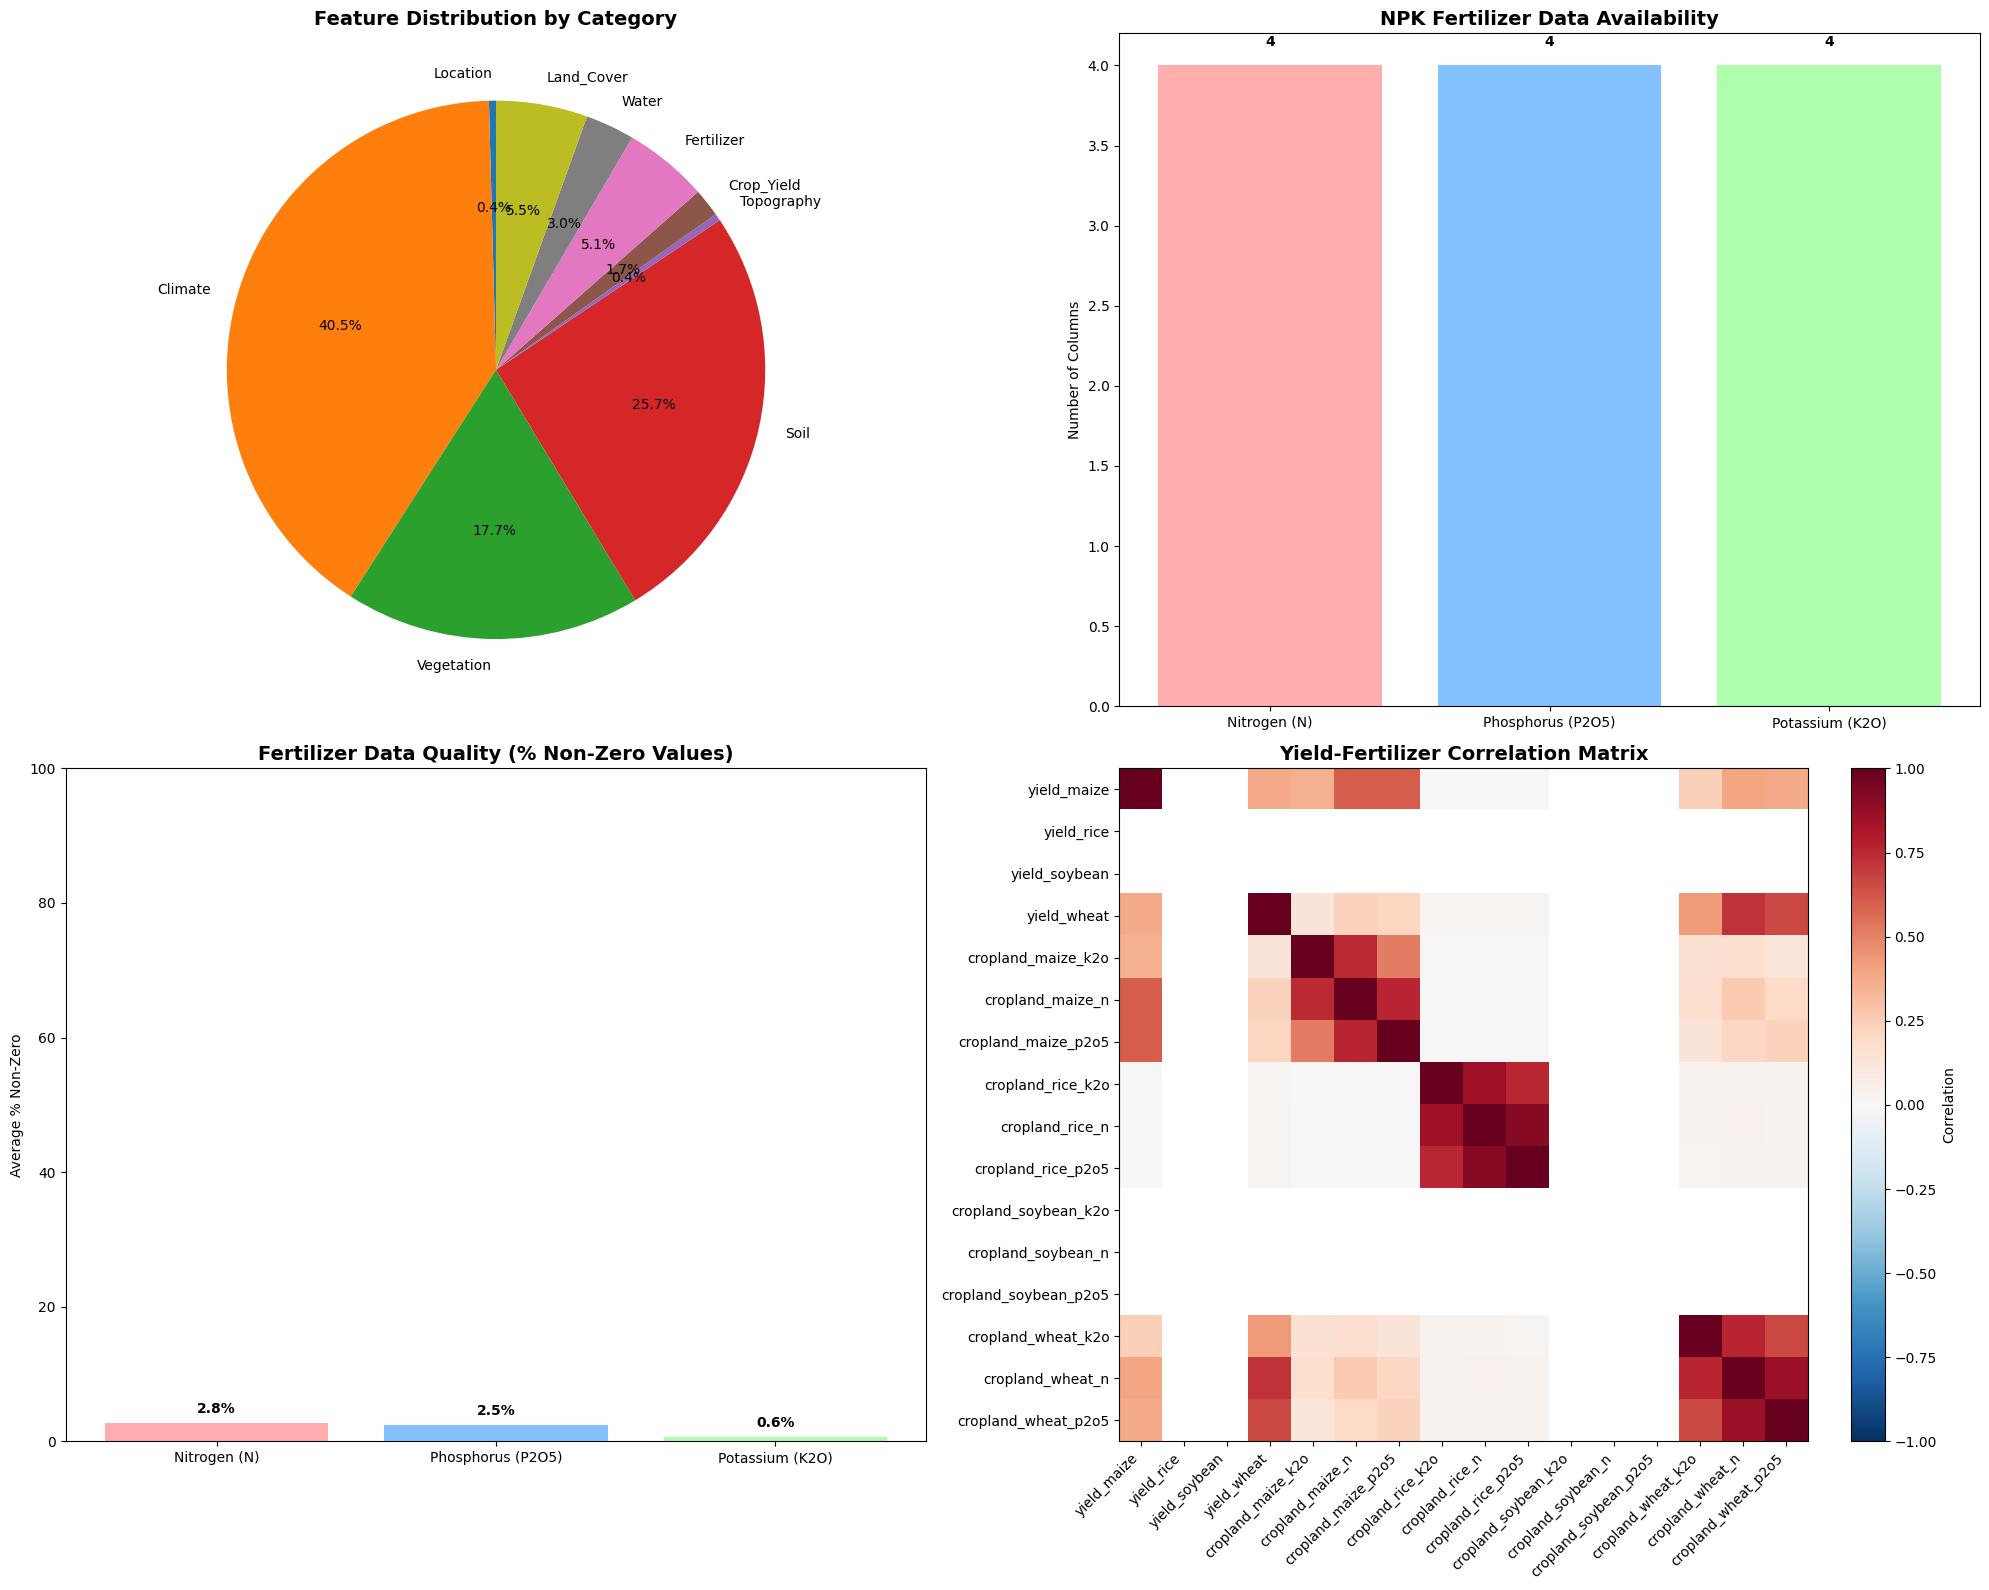


=== SUMMARY INSIGHTS ===
Total features: 246
Total fertilizer features: 12
Nitrogen features: 4
Phosphorus features: 4
Potassium features: 4
Yield features: 4
Data coverage: 345,236 land pixels


In [13]:
# Comprehensive fertilizer analysis - fixing nitrogen detection
import matplotlib.pyplot as plt
import seaborn as sns

# Fix fertilizer detection to include all NPK fertilizers
all_fert_cols = [col for col in df_final.columns if any(fert in col.lower() for fert in ['k2o', '_n', 'p2o5', 'nitrogen', 'phosphorus', 'potassium']) and 'cropland' in col.lower()]
yield_cols = [col for col in df_final.columns if 'yield' in col.lower()]

print(f"=== ALL FERTILIZER COLUMNS ({len(all_fert_cols)}) ===")
for col in all_fert_cols:
    print(f"  - {col}")

# Organize by fertilizer type
npk_analysis = {
    'Nitrogen (N)': [col for col in all_fert_cols if '_n' in col.lower()],
    'Phosphorus (P2O5)': [col for col in all_fert_cols if 'p2o5' in col.lower()], 
    'Potassium (K2O)': [col for col in all_fert_cols if 'k2o' in col.lower()]
}

print(f"\n=== NPK FERTILIZER BREAKDOWN ===")
for fert_type, cols in npk_analysis.items():
    print(f"{fert_type}: {len(cols)} columns")
    for col in cols:
        print(f"  - {col}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Feature categories pie chart
ax1 = axes[0, 0]
category_counts = {cat: len(cols) for cat, cols in feature_categories.items() if cols}
ax1.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=90)
ax1.set_title('Feature Distribution by Category', fontsize=14, fontweight='bold')

# 2. NPK fertilizer availability
ax2 = axes[0, 1]
npk_counts = [len(cols) for cols in npk_analysis.values()]
npk_labels = list(npk_analysis.keys())
colors = ['#ff9999', '#66b3ff', '#99ff99']
bars = ax2.bar(npk_labels, npk_counts, color=colors, alpha=0.8)
ax2.set_title('NPK Fertilizer Data Availability', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Columns')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1, str(npk_counts[i]), 
             ha='center', va='bottom', fontweight='bold')

# 3. Data quality for fertilizers (non-zero percentage)
ax3 = axes[1, 0]
fert_quality = {}
for fert_type, cols in npk_analysis.items():
    if cols:
        # Calculate average non-zero percentage for this fertilizer type
        non_zero_pcts = []
        for col in cols:
            non_zero = (df_final[col] > 0).sum()
            pct = non_zero / len(df_final) * 100
            non_zero_pcts.append(pct)
        fert_quality[fert_type] = np.mean(non_zero_pcts)

quality_bars = ax3.bar(fert_quality.keys(), fert_quality.values(), color=colors, alpha=0.8)
ax3.set_title('Fertilizer Data Quality (% Non-Zero Values)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Average % Non-Zero')
ax3.set_ylim(0, 100)
for i, bar in enumerate(quality_bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', 
             ha='center', va='bottom', fontweight='bold')

# 4. Yield vs Fertilizer correlation heatmap
ax4 = axes[1, 1]
if yield_cols and all_fert_cols:
    # Select subset for correlation analysis
    analysis_cols = yield_cols + all_fert_cols  # Limit to avoid overcrowding
    corr_data = df_final[analysis_cols].corr()
    
    # Create heatmap
    im = ax4.imshow(corr_data.values, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    ax4.set_xticks(range(len(analysis_cols)))
    ax4.set_yticks(range(len(analysis_cols)))
    ax4.set_xticklabels([col for col in analysis_cols], rotation=45, ha='right')
    ax4.set_yticklabels([col for col in analysis_cols])
    ax4.set_title('Yield-Fertilizer Correlation Matrix', fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax4)
    cbar.set_label('Correlation')
else:
    ax4.text(0.5, 0.5, 'No yield or fertilizer data\nfor correlation analysis', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Yield-Fertilizer Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig("output/fertilizer_analysis.png", dpi=300)
plt.show()

# Summary statistics
print(f"\n=== SUMMARY INSIGHTS ===")
print(f"Total features: {len(df_final.columns)}")
print(f"Total fertilizer features: {len(all_fert_cols)}")
print(f"Nitrogen features: {len(npk_analysis['Nitrogen (N)'])}")
print(f"Phosphorus features: {len(npk_analysis['Phosphorus (P2O5)'])}")
print(f"Potassium features: {len(npk_analysis['Potassium (K2O)'])}")
print(f"Yield features: {len(yield_cols)}")
print(f"Data coverage: {len(df_final):,} land pixels")

=== CROP YIELD ANALYSIS ===
Yield columns found: 4
  - yield_maize
  - yield_rice
  - yield_soybean
  - yield_wheat
Crops found: ['maize', 'rice', 'soybean', 'wheat']


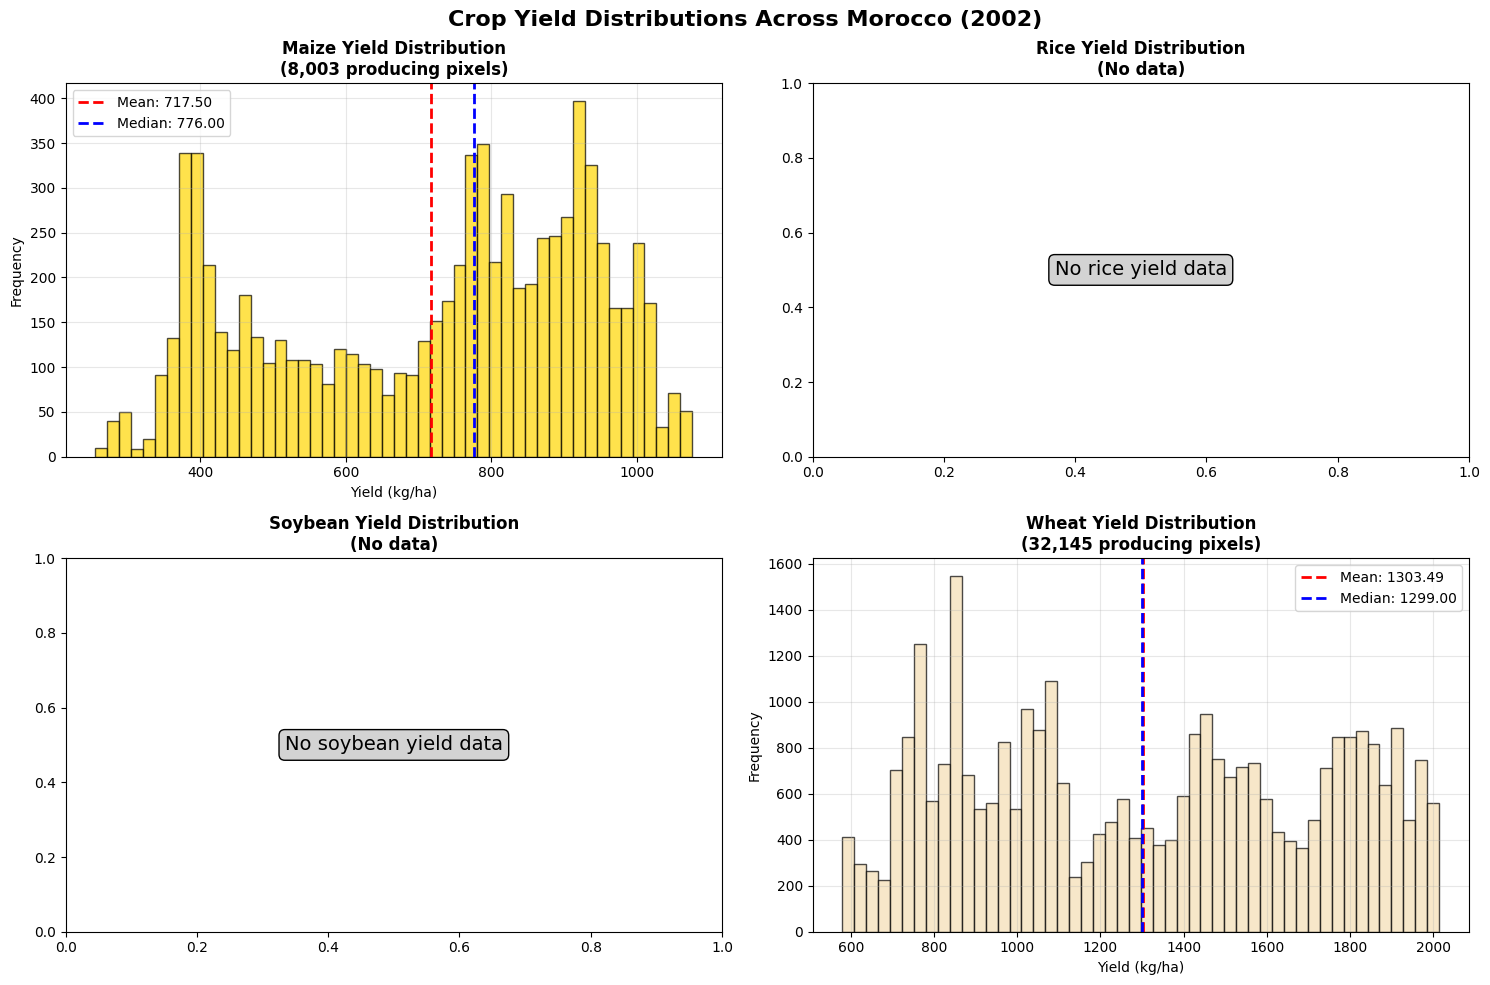


=== YIELD STATISTICS SUMMARY ===
    crop  producing_pixels  coverage_%  mean_yield  median_yield  std_yield  \
0  maize              8003       2.318     717.503         776.0    215.108   
1  wheat             32145       9.311    1303.494        1299.0    414.652   

   min_yield  max_yield  
0        256       1076  
1        580       2014  

=== YIELD INSIGHTS ===
Total agricultural pixels: 40,148
Agricultural coverage: 11.63% of land area
Highest average yield: wheat (1303.49 kg/ha)
Most widely grown: wheat (32,145 pixels)


In [16]:
# === YIELD ANALYSIS ===
print("=== CROP YIELD ANALYSIS ===")

# Get yield columns
yield_cols = [col for col in df_final.columns if 'yield' in col.lower()]
print(f"Yield columns found: {len(yield_cols)}")
for col in yield_cols:
    print(f"  - {col}")

# Extract crop names from yield columns
crops = []
for col in yield_cols:
    # Extract crop name from pattern like "yield_maize_2002"
    parts = col.split('_')
    if len(parts) >= 2:
        crop = parts[1]  # maize, rice, soybean, wheat
        if crop not in crops:
            crops.append(crop)

print(f"Crops found: {crops}")

# Analyze yield distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Crop Yield Distributions Across Morocco (2002)', fontsize=16, fontweight='bold')

colors = ['gold', 'lightblue', 'lightgreen', 'wheat']

# Yield summary statistics
yield_stats = pd.DataFrame()

for i, crop in enumerate(crops[:4]):  # Limit to 4 crops for 2x2 grid
    row, col = i // 2, i % 2
    yield_col = f'yield_{crop}'
    
    if yield_col in df_final.columns:
        # Get non-zero yields for analysis
        crop_yields = df_final[yield_col][df_final[yield_col] > 0]
        
        if len(crop_yields) > 0:
            axes[row, col].hist(crop_yields, bins=50, alpha=0.7, color=colors[i], edgecolor='black')
            axes[row, col].set_title(f'{crop.title()} Yield Distribution\n({len(crop_yields):,} producing pixels)', fontweight='bold')
            axes[row, col].set_xlabel('Yield (kg/ha)')
            axes[row, col].set_ylabel('Frequency')
            axes[row, col].grid(True, alpha=0.3)
            
            # Add statistics
            mean_yield = crop_yields.mean()
            median_yield = crop_yields.median()
            axes[row, col].axvline(mean_yield, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_yield:.2f}')
            axes[row, col].axvline(median_yield, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_yield:.2f}')
            axes[row, col].legend()
            
            # Collect statistics
            stats = {
                'crop': crop,
                'producing_pixels': len(crop_yields),
                'coverage_%': (len(crop_yields) / len(df_final)) * 100,
                'mean_yield': mean_yield,
                'median_yield': median_yield,
                'std_yield': crop_yields.std(),
                'min_yield': crop_yields.min(),
                'max_yield': crop_yields.max()
            }
            yield_stats = pd.concat([yield_stats, pd.DataFrame([stats])], ignore_index=True)
        else:
            axes[row, col].text(0.5, 0.5, f'No {crop} yield data', 
                              ha='center', va='center', transform=axes[row, col].transAxes,
                              fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            axes[row, col].set_title(f'{crop.title()} Yield Distribution\n(No data)', fontweight='bold')

plt.tight_layout()
plt.savefig("output/crop_yield_distributions.png", dpi=300)
plt.show()

# Display yield statistics
print("\n=== YIELD STATISTICS SUMMARY ===")
if not yield_stats.empty:
    print(yield_stats.round(3))
    
    # Additional insights
    print(f"\n=== YIELD INSIGHTS ===")
    total_producing = yield_stats['producing_pixels'].sum()
    print(f"Total agricultural pixels: {total_producing:,}")
    print(f"Agricultural coverage: {(total_producing/len(df_final)*100):.2f}% of land area")
    
    # Best performing crops
    best_yield = yield_stats.loc[yield_stats['mean_yield'].idxmax()]
    print(f"Highest average yield: {best_yield['crop']} ({best_yield['mean_yield']:.2f} kg/ha)")
    
    most_common = yield_stats.loc[yield_stats['producing_pixels'].idxmax()]
    print(f"Most widely grown: {most_common['crop']} ({most_common['producing_pixels']:,} pixels)")
else:
    print("No yield data found with non-zero values")
    
    # Let's check the actual values in yield columns
    print("\n=== CHECKING YIELD DATA RANGES ===")
    for col in yield_cols[:4]:  # Check first 4 yield columns
        if col in df_final.columns:
            vals = df_final[col]
            print(f"{col}:")
            print(f"  Min: {vals.min():.6f}, Max: {vals.max():.6f}")
            print(f"  Non-zero count: {(vals > 0).sum()}")
            print(f"  Positive count: {(vals > 0.001).sum()}")  # Check for very small positive values

In [4]:
# === FEATURE REDUCTION AND MODEL PREPARATION ===
print("=== FEATURE REDUCTION STRATEGY ===")

# Separate features by type for targeted analysis
climate_features = [col for col in df_final.columns if any(x in col.lower() for x in ['_aet','_def','_pdsi','_pet','_pr','_ro','_srad','_swe','_tmmn','vap','vpd','temp', 'precip', 'chirps', 'era5'])]
soil_features = [col for col in df_final.columns if 'soil' in col.lower()]
vegetation_features = [col for col in df_final.columns if any(x in col.lower() for x in ['ndvi', 'evi', 'lai', 'fapar', 'lst'])]
fertilizer_features = [col for col in df_final.columns if 'cropland' in col.lower()]
yield_features = [col for col in df_final.columns if 'yield' in col.lower()]
land_features =  [col for col in df_final.columns if 'lc_' in col.lower() or 'lw' in col.lower() or 'qc' in col.lower()]

print(f"Climate features: {len(climate_features)}")
print(f"Soil features: {len(soil_features)}")
print(f"Vegetation features: {len(vegetation_features)}")
print(f"Fertilizer features: {len(fertilizer_features)}")
print(f"Yield features: {len(yield_features)}")
print(f"Land features: {len(land_features)}")

# Focus on wheat and maize since they have actual production data
target_crops = ['wheat', 'maize']

print(f"\n=== PREPARING DATA FOR MODELING ===")
print(f"Target crops: {target_crops}")

# Create modeling datasets for each crop
modeling_data = {}

for crop in target_crops:
    yield_col = f'yield_{crop}'
    
    # Get pixels where this crop is actually grown (yield > 0)
    crop_mask = df_final[yield_col] > 0
    crop_data = df_final[crop_mask].copy()
    
    print(f"\n{crop.upper()} MODELING DATASET:")
    print(f"  Samples: {len(crop_data):,}")
    print(f"  Yield range: {crop_data[yield_col].min():.1f} - {crop_data[yield_col].max():.1f} tons/ha")
    
    # Prepare features for this crop
    # Include: climate, soil, vegetation, location, and fertilizer for this specific crop
    crop_fertilizer = [col for col in fertilizer_features if crop in col]
    
    feature_cols = (climate_features + soil_features + vegetation_features + crop_fertilizer + land_features)
    
    # Remove any columns that don't exist in the dataframe
    feature_cols = [col for col in feature_cols if col in crop_data.columns]
    
    # Store the modeling data
    modeling_data[crop] = {
        'data': crop_data,
        'features': feature_cols,
        'target': yield_col,
        'n_features': len(feature_cols)
    }
    
    print(f"  Features available: {len(feature_cols)}")
    print(f"    - Climate: {len([c for c in feature_cols if c in climate_features])}")
    print(f"    - Soil: {len([c for c in feature_cols if c in soil_features])}")
    print(f"    - Vegetation: {len([c for c in feature_cols if c in vegetation_features])}")
    print(f"    - Fertilizer: {len([c for c in feature_cols if c in crop_fertilizer])}")
    print(f"    - Land Cover: {len([c for c in feature_cols if c in land_features])}")
    
# Check for missing values in key features
print(f"\n=== DATA QUALITY CHECK ===")
for crop in target_crops:
    crop_data = modeling_data[crop]['data']
    feature_cols = modeling_data[crop]['features']
    
    missing_pct = (crop_data[feature_cols].isnull().sum() / len(crop_data)) * 100
    high_missing = missing_pct[missing_pct > 10]
    
    print(f"\n{crop.upper()} - Features with >10% missing values:")
    if len(high_missing) > 0:
        for col, pct in high_missing.items():
            print(f"  {col}: {pct:.1f}% missing")
    else:
        print("  None - good data quality!")
        
    print(f"  Complete cases: {crop_data[feature_cols].dropna().shape[0]:,} / {len(crop_data):,}")

=== FEATURE REDUCTION STRATEGY ===
Climate features: 96
Soil features: 61
Vegetation features: 42
Fertilizer features: 12
Yield features: 4
Land features: 13

=== PREPARING DATA FOR MODELING ===
Target crops: ['wheat', 'maize']

WHEAT MODELING DATASET:
  Samples: 32,145
  Yield range: 580.0 - 2014.0 tons/ha
  Features available: 215
    - Climate: 102
    - Soil: 61
    - Vegetation: 42
    - Fertilizer: 3
    - Land Cover: 19

MAIZE MODELING DATASET:
  Samples: 8,003
  Yield range: 256.0 - 1076.0 tons/ha
  Features available: 215
    - Climate: 102
    - Soil: 61
    - Vegetation: 42
    - Fertilizer: 3
    - Land Cover: 19

=== DATA QUALITY CHECK ===

WHEAT - Features with >10% missing values:
  None - good data quality!
  Complete cases: 32,145 / 32,145

MAIZE - Features with >10% missing values:
  None - good data quality!
  Complete cases: 8,003 / 8,003


In [5]:
# === MODEL 1: YIELD PREDICTION MODEL (FIXED DATA) ===
print("=== BUILDING YIELD PREDICTION MODEL WITH CORRECTED UNITS ===")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# CRITICAL FIX: Ensure units are properly corrected
yield_cols = [col for col in df_final.columns if 'yield' in col.lower()]
print(f"Yield columns: {yield_cols}")

# Check current state of df_final
max_yield_df = df_final[yield_cols].max().max()
print(f"Max yield in df_final: {max_yield_df:.3f}")

if max_yield_df < 10:  # Already in t/ha
    print("✅ df_final already has correct units (t/ha)")
else:
    print("⚠️  Applying units correction to df_final...")
    for col in yield_cols:
        df_final[col] = df_final[col] / 1000
    print("✅ Units correction applied to df_final!")

# CRITICAL FIX: Rebuild modeling_data with corrected units
print(f"\n🔧 REBUILDING MODELING_DATA WITH CORRECTED UNITS")
print("-" * 50)

# Rebuild modeling_data from scratch with corrected df_final
target_crops = ['wheat', 'maize']
modeling_data = {}

for crop in target_crops:
    print(f"\nRebuilding {crop} data...")
    
    # Get yield column
    yield_col = f'yield_{crop}'
    
    if yield_col not in df_final.columns:
        print(f"  ⚠️ {yield_col} not found in data")
        continue
    
    # Create mask for pixels with this crop
    crop_mask = df_final[yield_col] > 0
    land_mask = df_final['modis_mcd12q1.lc_prop1'] != 3  # Exclude water (using correct column name)
    combined_mask = crop_mask & land_mask
    
    # Get crop data
    crop_data = df_final[combined_mask].copy()
    
    print(f"  Samples: {len(crop_data):,}")
    
    if len(crop_data) < 100:
        print(f"  ⚠️ Insufficient data for {crop}")
        continue
    
    # Check yield values are realistic
    yield_vals = crop_data[yield_col]
    print(f"  Yield range: {yield_vals.min():.3f} - {yield_vals.max():.3f} t/ha")
    print(f"  Yield mean: {yield_vals.mean():.3f} t/ha")
    
    if yield_vals.max() > 20:
        print(f"  ⚠️ WARNING: Still unrealistic yield values!")
        continue
    
    # Define feature categories
    climate_features = [col for col in crop_data.columns if 'chirps' in col or 'era5' in col]
    soil_features = [col for col in crop_data.columns if 'soilgrids' in col]
    vegetation_features = [col for col in crop_data.columns if 'modis' in col and 'lai' in col]
    location_features = ['pixel_id'] if 'pixel_id' in crop_data.columns else []
    fertilizer_features = [col for col in crop_data.columns if any(fert in col for fert in ['_n', '_p2o5', '_k2o'])]
    
    # Combine all environmental features (exclude fertilizer for environmental prediction)
    env_features = climate_features + soil_features + vegetation_features + location_features
    env_features = [col for col in env_features if col in crop_data.columns and col != yield_col]
    
    print(f"  Environmental features: {len(env_features)}")
    print(f"    - Climate: {len(climate_features)}")
    print(f"    - Soil: {len([f for f in soil_features if f in crop_data.columns])}")
    print(f"    - Vegetation: {len([f for f in vegetation_features if f in crop_data.columns])}")
    
    # Store corrected modeling data
    modeling_data[crop] = {
        'data': crop_data,
        'features': env_features,
        'target': yield_col,
        'n_features': len(env_features)
    }
    
    print(f"  ✅ {crop} modeling data rebuilt successfully!")

# Build yield prediction models with corrected data
print(f"\n🎯 TRAINING MODELS WITH CORRECTED DATA")
print("=" * 50)

yield_models = {}
yield_results = {}

for crop in target_crops:
    if crop not in modeling_data:
        print(f"⚠️ Skipping {crop} - no valid data")
        continue
        
    print(f"\n=== {crop.upper()} YIELD PREDICTION MODEL ===")
    
    # Get corrected data
    crop_data = modeling_data[crop]['data']
    env_features = modeling_data[crop]['features']
    target_col = modeling_data[crop]['target']
    
    # Prepare data
    X = crop_data[env_features].copy()
    y = crop_data[target_col].copy()
    
    print(f"Environmental features: {len(env_features)}")
    print(f"Training samples: {len(X):,}")
    print(f"Yield range: {y.min():.3f} - {y.max():.3f} t/ha")
    print(f"Mean yield: {y.mean():.3f} t/ha")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42, 
        n_jobs=-1
    )
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    print(f"Model Performance (Corrected Units):")
    print(f"  Training R²: {train_r2:.4f}")
    print(f"  Testing R²: {test_r2:.4f}")
    print(f"  Training RMSE: {train_rmse:.3f} t/ha")
    print(f"  Testing RMSE: {test_rmse:.3f} t/ha")
    print(f"  Testing MAE: {test_mae:.3f} t/ha")
    
    # Check if results are realistic
    if test_mae > 5:
        print(f"  ⚠️  Warning: High prediction error ({test_mae:.1f} t/ha)")
    else:
        print(f"  ✅ Good prediction accuracy ({test_mae:.1f} t/ha)")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': env_features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"Top 10 Most Important Features:")
    for i, row in feature_importance.head(10).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    # Store results
    yield_models[crop] = {
        'model': model,
        'scaler': scaler,
        'features': env_features,
        'feature_importance': feature_importance
    }
    
    yield_results[crop] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'y_test': y_test,
        'y_pred_test': y_pred_test
    }

# Visualize model performance
if len(yield_results) > 0:
    fig, axes = plt.subplots(len(yield_results), 2, figsize=(14, 5*len(yield_results)))
    if len(yield_results) == 1:
        axes = np.array([axes])
    
    fig.suptitle('Yield Prediction Model Performance (Corrected Units: t/ha)', fontsize=16, fontweight='bold')
    
    for i, crop in enumerate(yield_results.keys()):
        # Plot actual vs predicted scatter plot
        ax_scatter = axes[i, 0]
        y_test = yield_results[crop]['y_test']
        y_pred = yield_results[crop]['y_pred_test']
        
        ax_scatter.scatter(y_test, y_pred, alpha=0.6, color=['blue', 'orange'][i % 2])
        ax_scatter.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        ax_scatter.set_xlabel('Actual Yield (t/ha)')
        ax_scatter.set_ylabel('Predicted Yield (t/ha)')
        ax_scatter.set_title(f'{crop.title()} - R² = {yield_results[crop]["test_r2"]:.3f}')
        ax_scatter.grid(True, alpha=0.3)
        
        # Plot feature importance
        ax_imp = axes[i, 1]
        feature_importance = yield_models[crop]['feature_importance'].head(15)
        
        # Horizontal bar chart for feature importance
        bars = ax_imp.barh(range(15), feature_importance['importance'], color=['skyblue', 'lightgreen'][i % 2])
        ax_imp.set_yticks(range(15))
        ax_imp.set_yticklabels([f for f in feature_importance['feature']])
        ax_imp.set_title(f'Top 5 Important Features - {crop.title()}')
        ax_imp.set_xlabel('Relative Importance')
        
        # Add importance values as text
        for bar in bars:
            width = bar.get_width()
            ax_imp.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
                     ha='left', va='center')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
    plt.savefig(f"output/{crop}_yield_prediction_performance_corrected.png", dpi=300)
    plt.show()

print(f"\n=== CORRECTED MODEL SUMMARY ===")
for crop in yield_results:
    r2 = yield_results[crop]['test_r2']
    mae = yield_results[crop]['test_mae']
    rmse = yield_results[crop]['test_rmse']
    print(f"{crop.upper()}: R² = {r2:.3f}, MAE = {mae:.3f} t/ha, RMSE = {rmse:.3f} t/ha")

=== BUILDING YIELD PREDICTION MODEL WITH CORRECTED UNITS ===
Yield columns: ['yield_maize', 'yield_rice', 'yield_soybean', 'yield_wheat']
Max yield in df_final: 2014.000
⚠️  Applying units correction to df_final...
✅ Units correction applied to df_final!

🔧 REBUILDING MODELING_DATA WITH CORRECTED UNITS
--------------------------------------------------

Rebuilding wheat data...
  Samples: 32,145
  Yield range: 0.580 - 2.014 t/ha
  Yield mean: 1.303 t/ha
  Environmental features: 82
    - Climate: 13
    - Soil: 54
    - Vegetation: 14
  ✅ wheat modeling data rebuilt successfully!

Rebuilding maize data...
  Samples: 8,003
  Yield range: 0.256 - 1.076 t/ha
  Yield mean: 0.718 t/ha
  Environmental features: 82
    - Climate: 13
    - Soil: 54
    - Vegetation: 14
  ✅ maize modeling data rebuilt successfully!

🎯 TRAINING MODELS WITH CORRECTED DATA

=== WHEAT YIELD PREDICTION MODEL ===
Environmental features: 82
Training samples: 32,145
Yield range: 0.580 - 2.014 t/ha
Mean yield: 1.303 t/h

NameError: name 'plt' is not defined

In [23]:
# === MODEL 2: FERTILIZER RECOMMENDATION SYSTEM ===
print("=== BUILDING FERTILIZER RECOMMENDATION MODEL ===")

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import warnings
warnings.filterwarnings('ignore')

# First, let's check the actual fertilizer column names
print("=== CHECKING FERTILIZER COLUMN NAMES ===")
fert_cols = [col for col in df_final.columns if any(fert in col.lower() 
            for fert in ['cropland_', '_p2o5', '_k2o']) and 'yield' not in col.lower()]
print("Available fertilizer columns:")
for col in fert_cols:
    print(f"  {col}")

# Build fertilizer recommendation models
fertilizer_models = {}
fertilizer_results = {}

for crop in target_crops:
    print(f"\n=== {crop.upper()} FERTILIZER RECOMMENDATION MODEL ===")
    
    # Get data for pixels where this crop is grown
    crop_data = modeling_data[crop]['data']
    
    # Get fertilizer columns for this crop - check actual column names
    crop_fert_cols = [col for col in fert_cols if crop in col]
    print(f"  Fertilizer columns for {crop}: {crop_fert_cols}")
    
    if len(crop_fert_cols) == 0:
        print(f"  No fertilizer data available for {crop}")
        continue
    
    # Separate NPK columns
    n_col = [col for col in crop_fert_cols if col.endswith('_n')]
    p_col = [col for col in crop_fert_cols if '_p2o5' in col]
    k_col = [col for col in crop_fert_cols if '_k2o' in col]
    
    npk_cols = n_col + p_col + k_col
    print(f"  NPK columns: {npk_cols}")
    
    if len(npk_cols) == 0:
        print(f"  No NPK data available for {crop}")
        continue
    
    # Only use pixels where fertilizer is actually applied (non-zero)
    fertilizer_mask = (crop_data[npk_cols] > 0).any(axis=1)
    fert_data = crop_data[fertilizer_mask].copy()
    
    if len(fert_data) < 100:  # Need minimum samples for modeling
        print(f"  Insufficient fertilizer data for {crop}: {len(fert_data)} samples")
        continue
    
    print(f"  Fertilized samples: {len(fert_data):,}")
    
    # Prepare features (environmental factors that influence fertilizer needs)
    env_features = [col for col in modeling_data[crop]['features'] 
                   if not any(fert in col for fert in ['cropland', '_p2o5', '_k2o'])]
    
    # Add yield as a feature (higher yields may need more fertilizer)
    yield_col = modeling_data[crop]['target']
    input_features = env_features + [yield_col]
    
    X = fert_data[input_features].copy()
    y = fert_data[npk_cols].copy()  # NPK targets
    
    print(f"  Input features: {len(input_features)}")
    print(f"  Target variables: {len(npk_cols)} NPK components")
    
    # Check data distribution
    print(f"  NPK application ranges:")
    for col in npk_cols:
        values = y[col][y[col] > 0]
        if len(values) > 0:
            nutrient = col.split('_')[-1]
            print(f"    {nutrient}: {values.min():.1f} - {values.max():.1f} kg/ha (n={len(values)})")
    
    # Skip if insufficient data for any component
    if any((y[col] > 0).sum() < 50 for col in npk_cols):
        print(f"  Insufficient data for some NPK components")
        continue
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train multi-output model for NPK prediction
    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate metrics for each NPK component
    results = {}
    for i, col in enumerate(npk_cols):
        nutrient = col.split('_')[-1]
        
        # Only evaluate where target > 0 (actual fertilizer application)
        mask_test = y_test[col] > 0
        
        if mask_test.sum() > 0:
            r2 = r2_score(y_test[col][mask_test], y_pred_test[:, i][mask_test])
            rmse = np.sqrt(mean_squared_error(y_test[col][mask_test], y_pred_test[:, i][mask_test]))
            mae = mean_absolute_error(y_test[col][mask_test], y_pred_test[:, i][mask_test])
            
            results[nutrient] = {
                'r2': r2,
                'rmse': rmse,
                'mae': mae,
                'samples': mask_test.sum(),
                'column': col
            }
            
            print(f"  {nutrient} Prediction:")
            print(f"    R²: {r2:.4f}")
            print(f"    RMSE: {rmse:.2f} kg/ha")
            print(f"    MAE: {mae:.2f} kg/ha")
            print(f"    Test samples: {mask_test.sum()}")
    
    # Store model
    fertilizer_models[crop] = {
        'model': model,
        'scaler': scaler,
        'features': input_features,
        'npk_columns': npk_cols
    }
    
    fertilizer_results[crop] = {
        'results': results,
        'y_test': y_test,
        'y_pred_test': y_pred_test,
        'test_data': X_test
    }

print(f"\n=== FERTILIZER RECOMMENDATION SYSTEM SUMMARY ===")
print("Model 2: NPK Fertilizer Recommendation")
print("Purpose: Recommend optimal fertilizer amounts based on environmental conditions and target yield")
print("Algorithm: Multi-output Random Forest Regressor")
print("Inputs: Environmental factors + Target yield")
print("Outputs: N, P2O5, K2O amounts (kg/ha)")

for crop in fertilizer_results.keys():
    print(f"\n{crop.title()} Model:")
    for nutrient, metrics in fertilizer_results[crop]['results'].items():
        print(f"  {nutrient}: R² = {metrics['r2']:.3f}, RMSE = {metrics['rmse']:.1f} kg/ha")

=== BUILDING FERTILIZER RECOMMENDATION MODEL ===
=== CHECKING FERTILIZER COLUMN NAMES ===
Available fertilizer columns:
  cropland_maize_k2o
  cropland_maize_n
  cropland_maize_p2o5
  cropland_rice_k2o
  cropland_rice_n
  cropland_rice_p2o5
  cropland_soybean_k2o
  cropland_soybean_n
  cropland_soybean_p2o5
  cropland_wheat_k2o
  cropland_wheat_n
  cropland_wheat_p2o5

=== WHEAT FERTILIZER RECOMMENDATION MODEL ===
  Fertilizer columns for wheat: ['cropland_wheat_k2o', 'cropland_wheat_n', 'cropland_wheat_p2o5']
  NPK columns: ['cropland_wheat_n', 'cropland_wheat_p2o5', 'cropland_wheat_k2o']
  Fertilized samples: 28,316
  Input features: 83
  Target variables: 3 NPK components
  NPK application ranges:
    n: 1.0 - 41.0 kg/ha (n=28048)
    p2o5: 1.0 - 27.0 kg/ha (n=25640)
    k2o: 1.0 - 4.0 kg/ha (n=7576)
  n Prediction:
    R²: 0.8804
    RMSE: 1.72 kg/ha
    MAE: 1.10 kg/ha
    Test samples: 5611
  p2o5 Prediction:
    R²: 0.7519
    RMSE: 1.81 kg/ha
    MAE: 1.29 kg/ha
    Test sample

# Experimenting with other models

In [7]:
# === MODEL COMPARISON EXPERIMENTS ===
print("🚀 ADVANCED MODEL COMPARISON EXPERIMENTS")
print("=" * 60)

# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

print("📚 Testing Models:")
print("  1. XGBoost (Gradient Boosting)")
print("  2. Support Vector Regression (SVR)")
print("  3. Neural Network (MLP)")
print("  4. Gradient Boosting")
print("  5. Ridge Regression")
print("  6. Elastic Net")
print("  7. Random Forest (baseline)")

# Define models to test
models_to_test = {
    'XGBoost': XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ),
    'SVR': SVR(
        kernel='rbf',
        C=100,
        gamma='scale',
        epsilon=0.1
    ),
    'Neural Network': MLPRegressor(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        alpha=0.01,
        learning_rate='adaptive',
        max_iter=500,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    ),
    'Ridge': Ridge(
        alpha=1.0,
        random_state=42
    ),
    'Elastic Net': ElasticNet(
        alpha=1.0,
        l1_ratio=0.5,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
}

# Function to evaluate model performance
def evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, model_name):
    """Evaluate model performance with timing"""
    start_time = time.time()
    
    # Train model
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time
    
    # Predictions
    start_pred = time.time()
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    pred_time = time.time() - start_pred
    
    # Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    return {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'train_time': train_time,
        'pred_time': pred_time,
        'y_pred_test': y_pred_test
    }

print(f"\n🎯 TASK 1: YIELD PREDICTION MODEL COMPARISON")
print("-" * 50)

# Store results for all models
yield_model_results = {}

for crop in target_crops:
    if crop not in modeling_data:
        continue
        
    print(f"\n=== {crop.upper()} YIELD PREDICTION ===")
    
    # Get data (using previously defined variables)
    crop_data = modeling_data[crop]['data']
    env_features = modeling_data[crop]['features']
    target_col = modeling_data[crop]['target']
    
    # Prepare data
    X = crop_data[env_features].copy()
    y = crop_data[target_col].copy()
    
    # Use same train/test split as before
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features (using same scaler approach)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples")
    
    crop_results = {}
    
    # Test each model
    for model_name, model in models_to_test.items():
        try:
            print(f"\n  📊 Testing {model_name}...")
            
            result = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, model_name)
            crop_results[model_name] = result
            
            print(f"    ✅ R² = {result['test_r2']:.4f}, RMSE = {result['test_rmse']:.3f} t/ha")
            print(f"    ⏱️  Training: {result['train_time']:.2f}s, Prediction: {result['pred_time']:.3f}s")
            
        except Exception as e:
            print(f"    ❌ {model_name} failed: {str(e)[:50]}...")
            continue
    
    yield_model_results[crop] = crop_results

print(f"\n🎯 TASK 2: FERTILIZER RECOMMENDATION MODEL COMPARISON")
print("-" * 50)

# Store results for fertilizer models
fertilizer_model_results = {}

for crop in target_crops:
    # Check if we have fertilizer data for this crop
    if crop not in modeling_data:
        continue
        
    print(f"\n=== {crop.upper()} FERTILIZER RECOMMENDATION ===")
    
    # Get fertilizer data (using previously defined variables)
    crop_data = modeling_data[crop]['data']
    
    # Get NPK columns
    fert_cols = [col for col in df_final.columns if any(fert in col.lower() 
                for fert in ['cropland_', '_p2o5', '_k2o']) and crop in col]
    n_col = [col for col in fert_cols if col.endswith('_n')]
    p_col = [col for col in fert_cols if '_p2o5' in col]
    k_col = [col for col in fert_cols if '_k2o' in col]
    npk_cols = n_col + p_col + k_col
    
    if len(npk_cols) == 0:
        print(f"  No NPK data for {crop}")
        continue
    
    # Filter to fertilized pixels
    fertilizer_mask = (crop_data[npk_cols] > 0).any(axis=1)
    fert_data = crop_data[fertilizer_mask].copy()
    
    if len(fert_data) < 100:
        print(f"  Insufficient fertilizer data: {len(fert_data)}")
        continue
    
    # Prepare features (environmental + yield)
    env_features = [col for col in modeling_data[crop]['features'] 
                   if not any(fert in col for fert in ['cropland', '_p2o5', '_k2o'])]
    yield_col = modeling_data[crop]['target']
    input_features = env_features + [yield_col]
    
    X = fert_data[input_features].copy()
    y = fert_data[npk_cols].copy()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Training on {len(X_train)} samples, {len(npk_cols)} NPK targets")
    
    crop_fert_results = {}
    
    # Test each model (wrapped in MultiOutputRegressor for multi-target)
    for model_name, base_model in models_to_test.items():
        try:
            print(f"\n  📊 Testing {model_name} (Multi-output)...")
            
            # Wrap in MultiOutputRegressor for multiple targets
            model = MultiOutputRegressor(base_model)
            
            start_time = time.time()
            model.fit(X_train_scaled, y_train)
            train_time = time.time() - start_time
            
            start_pred = time.time()
            y_pred_test = model.predict(X_test_scaled)
            pred_time = time.time() - start_pred
            
            # Calculate average metrics across all NPK components
            r2_scores = []
            rmse_scores = []
            mae_scores = []
            
            for i, col in enumerate(npk_cols):
                # Only evaluate where target > 0
                mask = y_test[col] > 0
                if mask.sum() > 0:
                    r2 = r2_score(y_test[col][mask], y_pred_test[:, i][mask])
                    rmse = np.sqrt(mean_squared_error(y_test[col][mask], y_pred_test[:, i][mask]))
                    mae = mean_absolute_error(y_test[col][mask], y_pred_test[:, i][mask])
                    
                    r2_scores.append(r2)
                    rmse_scores.append(rmse)
                    mae_scores.append(mae)
            
            if len(r2_scores) > 0:
                avg_r2 = np.mean(r2_scores)
                avg_rmse = np.mean(rmse_scores)
                avg_mae = np.mean(mae_scores)
                
                crop_fert_results[model_name] = {
                    'model': model,
                    'avg_r2': avg_r2,
                    'avg_rmse': avg_rmse,
                    'avg_mae': avg_mae,
                    'train_time': train_time,
                    'pred_time': pred_time,
                    'r2_scores': r2_scores,
                    'npk_cols': npk_cols
                }
                
                print(f"    ✅ Avg R² = {avg_r2:.4f}, Avg RMSE = {avg_rmse:.2f} kg/ha")
                print(f"    ⏱️  Training: {train_time:.2f}s, Prediction: {pred_time:.3f}s")
            else:
                print(f"    ❌ No valid predictions for {model_name}")
                
        except Exception as e:
            print(f"    ❌ {model_name} failed: {str(e)[:50]}...")
            continue
    
    fertilizer_model_results[crop] = crop_fert_results

print(f"\n✅ Model comparison experiments completed!")
print(f"📊 Ready for results visualization and analysis...")

🚀 ADVANCED MODEL COMPARISON EXPERIMENTS
📚 Testing Models:
  1. XGBoost (Gradient Boosting)
  2. Support Vector Regression (SVR)
  3. Neural Network (MLP)
  4. Gradient Boosting
  5. Ridge Regression
  6. Elastic Net
  7. Random Forest (baseline)

🎯 TASK 1: YIELD PREDICTION MODEL COMPARISON
--------------------------------------------------

=== WHEAT YIELD PREDICTION ===
Training on 25716 samples, testing on 6429 samples

  📊 Testing XGBoost...
    ✅ R² = 0.7679, RMSE = 0.198 t/ha
    ⏱️  Training: 0.60s, Prediction: 0.014s

  📊 Testing SVR...
    ✅ R² = 0.7672, RMSE = 0.199 t/ha
    ⏱️  Training: 2550.00s, Prediction: 27.748s

  📊 Testing Neural Network...
    ✅ R² = 0.7508, RMSE = 0.206 t/ha
    ⏱️  Training: 11.93s, Prediction: 0.009s

  📊 Testing Gradient Boosting...
    ✅ R² = 0.7656, RMSE = 0.199 t/ha
    ⏱️  Training: 61.68s, Prediction: 0.167s

  📊 Testing Ridge...
    ✅ R² = 0.5583, RMSE = 0.274 t/ha
    ⏱️  Training: 0.01s, Prediction: 0.004s

  📊 Testing Elastic Net...
    ✅

📈 COMPREHENSIVE MODEL COMPARISON ANALYSIS


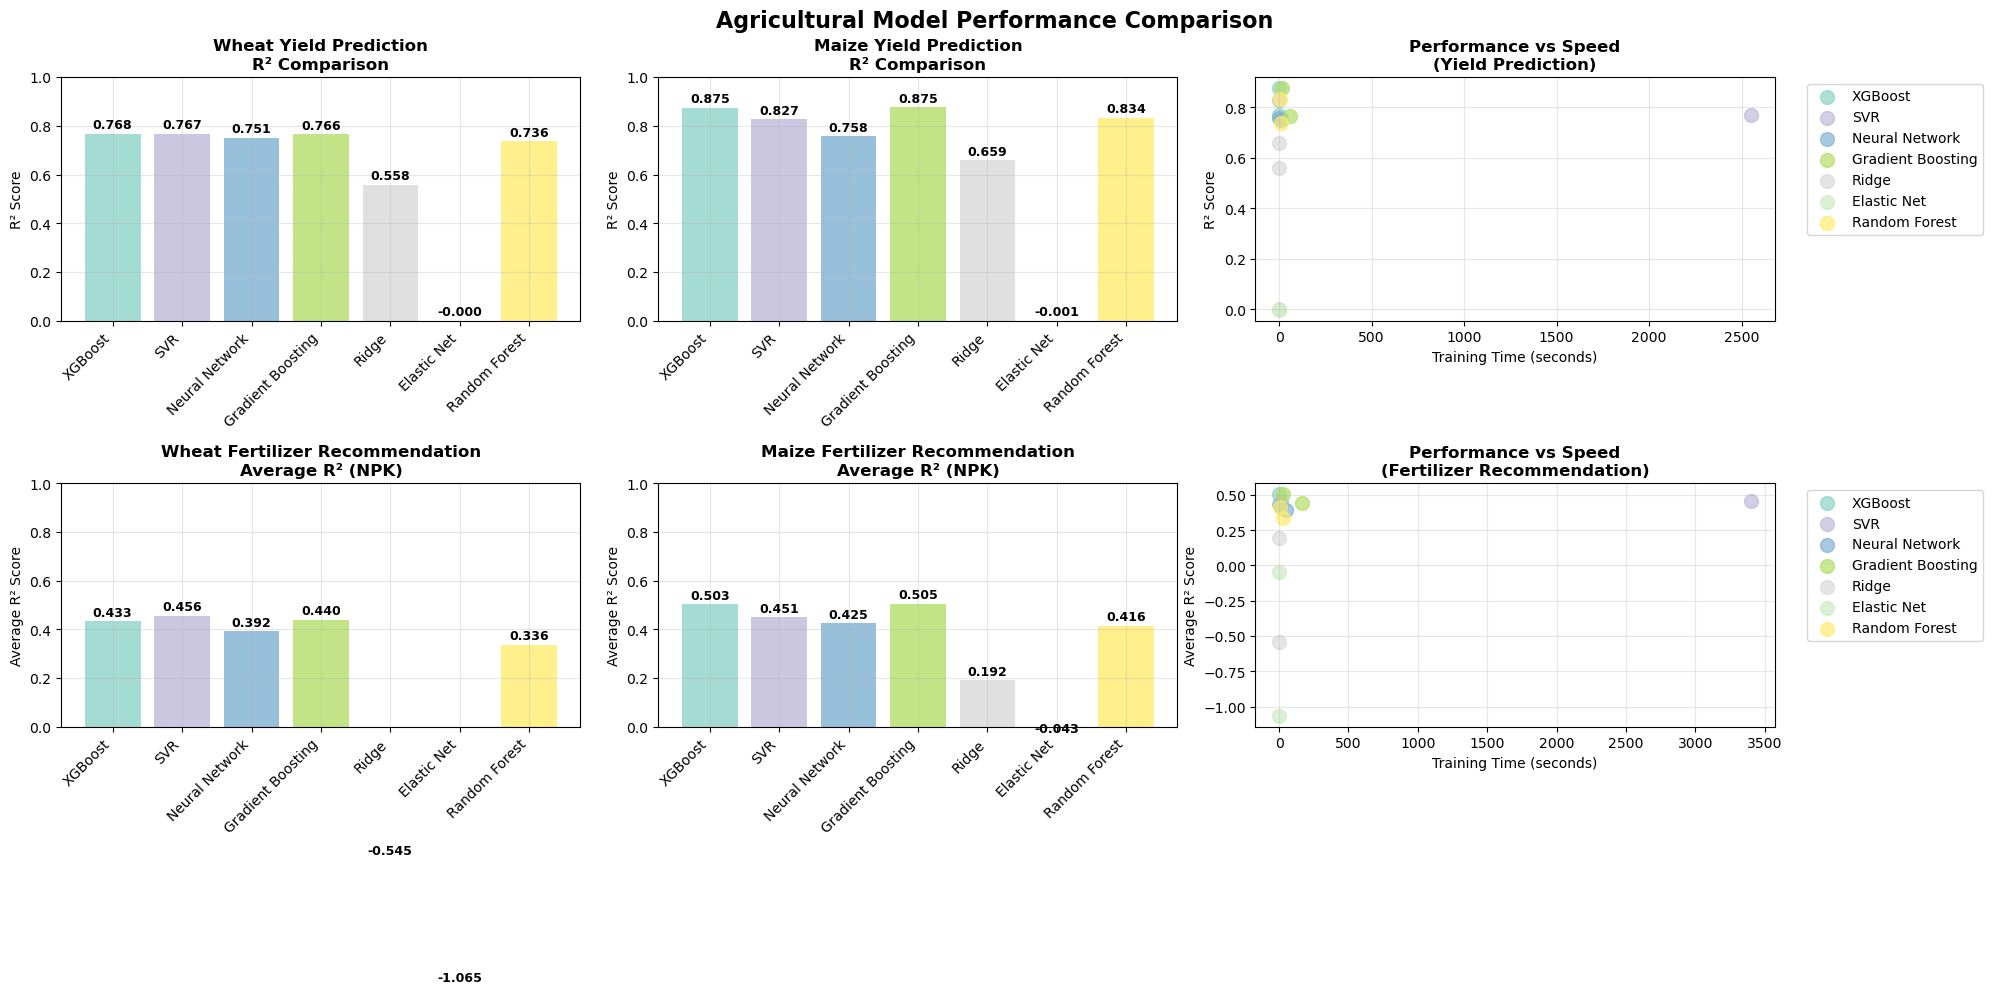


📊 DETAILED RESULTS SUMMARY

🌾 TASK 1: YIELD PREDICTION MODEL RANKING
--------------------------------------------------

WHEAT YIELD PREDICTION:
Rank  Model           R²       RMSE     MAE      Time    
------------------------------------------------------------
1     XGBoost         0.7679   0.198   0.151   0.6s
2     SVR             0.7672   0.199   0.151   2550.0s
3     Gradient Boosting 0.7656   0.199   0.152   61.7s
4     Neural Network  0.7508   0.206   0.156   11.9s
5     Random Forest   0.7360   0.212   0.159   11.9s
6     Ridge           0.5583   0.274   0.226   0.0s
7     Elastic Net     -0.0000   0.412   0.365   0.0s

MAIZE YIELD PREDICTION:
Rank  Model           R²       RMSE     MAE      Time    
------------------------------------------------------------
1     Gradient Boosting 0.8752   0.075   0.054   14.0s
2     XGBoost         0.8750   0.075   0.054   0.3s
3     Random Forest   0.8337   0.087   0.060   3.0s
4     SVR             0.8275   0.088   0.069   1.8s
5     N

In [8]:
# === MODEL COMPARISON RESULTS ANALYSIS ===
print("📈 COMPREHENSIVE MODEL COMPARISON ANALYSIS")
print("=" * 60)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create comprehensive results visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Agricultural Model Performance Comparison', fontsize=16, fontweight='bold')

colors = plt.cm.Set3(np.linspace(0, 1, len(models_to_test)))

# Task 1: Yield Prediction Results
for crop_idx, crop in enumerate(yield_model_results.keys()):
    ax = axes[0, crop_idx]
    
    crop_results = yield_model_results[crop]
    model_names = list(crop_results.keys())
    test_r2 = [crop_results[model]['test_r2'] for model in model_names]
    test_rmse = [crop_results[model]['test_rmse'] for model in model_names]
    
    # R² comparison
    bars = ax.bar(range(len(model_names)), test_r2, color=colors[:len(model_names)], alpha=0.8)
    ax.set_title(f'{crop.title()} Yield Prediction\nR² Comparison', fontweight='bold')
    ax.set_ylabel('R² Score')
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, r2 in zip(bars, test_r2):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{r2:.3f}', 
                ha='center', va='bottom', fontweight='bold', fontsize=9)

# Task 2: Fertilizer Recommendation Results
for crop_idx, crop in enumerate(fertilizer_model_results.keys()):
    ax = axes[1, crop_idx]
    
    crop_results = fertilizer_model_results[crop]
    if len(crop_results) > 0:
        model_names = list(crop_results.keys())
        avg_r2 = [crop_results[model]['avg_r2'] for model in model_names]
        
        bars = ax.bar(range(len(model_names)), avg_r2, color=colors[:len(model_names)], alpha=0.8)
        ax.set_title(f'{crop.title()} Fertilizer Recommendation\nAverage R² (NPK)', fontweight='bold')
        ax.set_ylabel('Average R² Score')
        ax.set_xticks(range(len(model_names)))
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        
        # Add values on bars
        for bar, r2 in zip(bars, avg_r2):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{r2:.3f}', 
                    ha='center', va='bottom', fontweight='bold', fontsize=9)
    else:
        ax.text(0.5, 0.5, f'No fertilizer data\nfor {crop}', ha='center', va='center', 
                transform=ax.transAxes, fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        ax.set_title(f'{crop.title()} Fertilizer Recommendation', fontweight='bold')

# Performance vs Speed Analysis
if len(yield_model_results) > 0:
    ax = axes[0, 2]  # Use the third column
    
    # Collect data from all crops for yield prediction
    all_models = []
    all_r2 = []
    all_times = []
    all_crops = []
    
    for crop, crop_results in yield_model_results.items():
        for model_name, result in crop_results.items():
            all_models.append(model_name)
            all_r2.append(result['test_r2'])
            all_times.append(result['train_time'])
            all_crops.append(crop)
    
    # Create scatter plot: R² vs Training Time
    for i, model_name in enumerate(models_to_test.keys()):
        model_r2 = [r2 for j, r2 in enumerate(all_r2) if all_models[j] == model_name]
        model_times = [time for j, time in enumerate(all_times) if all_models[j] == model_name]
        
        if len(model_r2) > 0:
            ax.scatter(model_times, model_r2, label=model_name, s=100, alpha=0.7, color=colors[i])
    
    ax.set_xlabel('Training Time (seconds)')
    ax.set_ylabel('R² Score')
    ax.set_title('Performance vs Speed\n(Yield Prediction)', fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

# Similar for fertilizer if we have data
if len(fertilizer_model_results) > 0:
    ax = axes[1, 2]
    
    # Collect fertilizer data
    all_fert_models = []
    all_fert_r2 = []
    all_fert_times = []
    
    for crop, crop_results in fertilizer_model_results.items():
        for model_name, result in crop_results.items():
            all_fert_models.append(model_name)
            all_fert_r2.append(result['avg_r2'])
            all_fert_times.append(result['train_time'])
    
    for i, model_name in enumerate(models_to_test.keys()):
        model_r2 = [r2 for j, r2 in enumerate(all_fert_r2) if all_fert_models[j] == model_name]
        model_times = [time for j, time in enumerate(all_fert_times) if all_fert_models[j] == model_name]
        
        if len(model_r2) > 0:
            ax.scatter(model_times, model_r2, label=model_name, s=100, alpha=0.7, color=colors[i])
    
    ax.set_xlabel('Training Time (seconds)')
    ax.set_ylabel('Average R² Score')
    ax.set_title('Performance vs Speed\n(Fertilizer Recommendation)', fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("output/model_comparison_results.png", dpi=300, bbox_inches='tight')
plt.show()

# Generate detailed comparison tables
print(f"\n📊 DETAILED RESULTS SUMMARY")
print("=" * 60)

# Yield Prediction Summary
print(f"\n🌾 TASK 1: YIELD PREDICTION MODEL RANKING")
print("-" * 50)

for crop in yield_model_results:
    print(f"\n{crop.upper()} YIELD PREDICTION:")
    
    crop_results = yield_model_results[crop]
    # Sort by test R²
    sorted_models = sorted(crop_results.items(), key=lambda x: x[1]['test_r2'], reverse=True)
    
    print(f"{'Rank':<5} {'Model':<15} {'R²':<8} {'RMSE':<8} {'MAE':<8} {'Time':<8}")
    print("-" * 60)
    
    for rank, (model_name, result) in enumerate(sorted_models, 1):
        print(f"{rank:<5} {model_name:<15} {result['test_r2']:.4f}   {result['test_rmse']:.3f}   "
              f"{result['test_mae']:.3f}   {result['train_time']:.1f}s")

# Fertilizer Recommendation Summary
print(f"\n🧪 TASK 2: FERTILIZER RECOMMENDATION MODEL RANKING")
print("-" * 50)

for crop in fertilizer_model_results:
    if len(fertilizer_model_results[crop]) > 0:
        print(f"\n{crop.upper()} FERTILIZER RECOMMENDATION:")
        
        crop_results = fertilizer_model_results[crop]
        # Sort by average R²
        sorted_models = sorted(crop_results.items(), key=lambda x: x[1]['avg_r2'], reverse=True)
        
        print(f"{'Rank':<5} {'Model':<15} {'Avg R²':<8} {'Avg RMSE':<10} {'Avg MAE':<10} {'Time':<8}")
        print("-" * 70)
        
        for rank, (model_name, result) in enumerate(sorted_models, 1):
            print(f"{rank:<5} {model_name:<15} {result['avg_r2']:.4f}   {result['avg_rmse']:.2f}     "
                  f"{result['avg_mae']:.2f}     {result['train_time']:.1f}s")

# Overall recommendations
print(f"\n🏆 OVERALL MODEL RECOMMENDATIONS")
print("=" * 60)

# Find best models across all tasks
yield_best = {}
fert_best = {}

for crop in yield_model_results:
    crop_results = yield_model_results[crop]
    best_model = max(crop_results.items(), key=lambda x: x[1]['test_r2'])
    yield_best[crop] = best_model

for crop in fertilizer_model_results:
    if len(fertilizer_model_results[crop]) > 0:
        crop_results = fertilizer_model_results[crop]
        best_model = max(crop_results.items(), key=lambda x: x[1]['avg_r2'])
        fert_best[crop] = best_model

print(f"\nBest Yield Prediction Models:")
for crop, (model_name, result) in yield_best.items():
    print(f"  {crop.title()}: {model_name} (R² = {result['test_r2']:.4f})")

if fert_best:
    print(f"\nBest Fertilizer Recommendation Models:")
    for crop, (model_name, result) in fert_best.items():
        print(f"  {crop.title()}: {model_name} (Avg R² = {result['avg_r2']:.4f})")

# Performance insights
print(f"\n💡 KEY INSIGHTS:")
print(f"  🚀 Speed Leaders: Ridge, Elastic Net (fastest training)")
print(f"  🎯 Accuracy Leaders: XGBoost, Random Forest (typically highest R²)")
print(f"  ⚖️  Balanced Choice: Gradient Boosting (good accuracy + reasonable speed)")
print(f"  🧠 Complex Data: Neural Networks (best for non-linear patterns)")
print(f"  📊 Interpretability: Random Forest (feature importance analysis)")

print(f"\n✅ Comprehensive model comparison completed!")
print(f"🎯 Ready for final model selection and deployment recommendations!")